In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import metrics
import scipy.cluster.hierarchy as sch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,recall_score, precision_score, ConfusionMatrixDisplay
from sklearn import set_config
set_config(display="diagram")

I will use the 'ld' data for analysis and visualization.

The 'df' data will be used for modeling and predictions.

In [ ]:
loan = '/content/lending_club_loan_dataset.csv'
ld = pd.read_csv(loan)
df = pd.read_csv(loan)
ld.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


**Prepare the Data for Modeling**

Change feature 'grade' from object to numerical values. Drop 'last_major_derog_none' and 'id' columns due to too much missing data. Fix inconsistencies in 'term' feature.

In [ ]:
df['grade'] = df['grade'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5,
                                   'G':6})
df = df.drop(columns=['last_major_derog_none','id'])
df['term'] = df['term'].replace([' 36 Months'], ' 36 months')

Identify the features (X) and target (y), where the "bad_loan" column is the target and the rest of the relevant variables as your features matrix. Then perform a train test split of the data.

In [ ]:
X = df.drop(columns = 'bad_loan')
y = df['bad_loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Instantiate Transformers: create preprocessing objects to prepare the dataset for Machine Learning.

In [ ]:
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

Create Pipeline for Numerical and Categorical Data.

In [ ]:
cat_pipe = make_pipeline(freq_imputer, ohe)
num_pipe = make_pipeline(mean_imputer, scaler)

Create Tuples to pair Pipelines with Selected Columns.

In [ ]:
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)

Instantiate the Column Transformer.

In [ ]:
preprocessor = make_column_transformer(cat_tuple, num_tuple, 
                                       remainder='passthrough')
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])

Logistic Regression Model (L1 Tuning)

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train, y_train)
print(logreg_pipe.score(X_train, y_train))
print(logreg_pipe.score(X_test, y_test))

0.8075333333333333
0.8012


The model determines the highest value would be when c = 1.

{1e-05: 0.7996,
 0.0001: 0.7996,
 0.001: 0.7996,
 0.01: 0.802,
 0.1: 0.801,
 1: 0.8016,
 10: 0.8012,
 100: 0.8012,
 1000: 0.8012,
 10000: 0.8012}

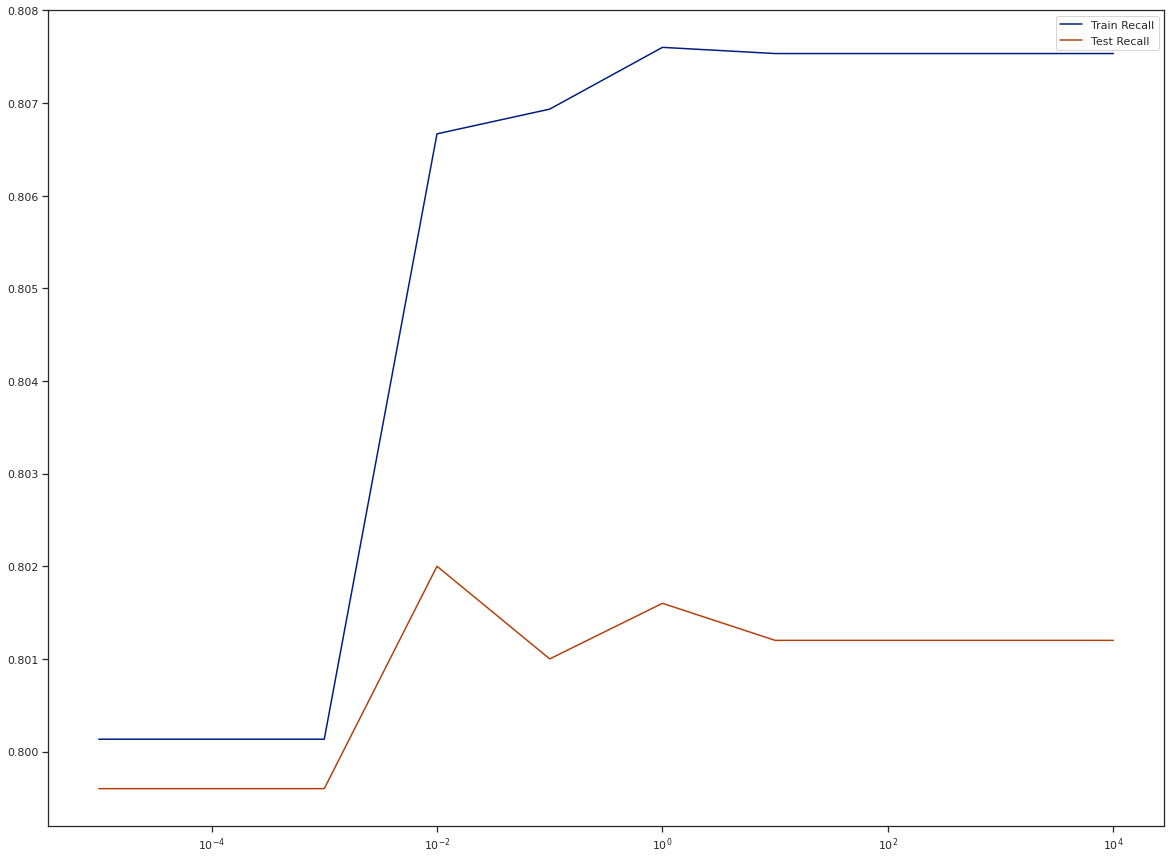

In [ ]:
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train_score = []
test_score = []

for c in c_values:
  logreg_l1 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  logreg_l1_pipe = make_pipeline(preprocessor, logreg_l1)
  logreg_l1_pipe.fit(X_train, y_train)

  train_score.append(logreg_l1_pipe.score(X_train, y_train))
  test_score.append(logreg_l1_pipe.score(X_test, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_score, label='Train Recall')
ax.plot(c_values, test_score, label='Test Recall')
ax.set_xticks(c_values)
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_score)}

In [ ]:
l1_01 = LogisticRegression(C=1, max_iter=1000, solver='liblinear', penalty='l1')
l1_01_pipe = make_pipeline(preprocessor, l1_01)
l1_01_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
l1_pred = l1_01_pipe.predict(X_test)
l1_pred

array([0, 0, 0, ..., 0, 0, 0])

From the Confusion Matrix below, we can see our true positives equate to 99% but our true negatives were 6.9%. The model predicted 93% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. It will create confusion and frustration among the borrowers.

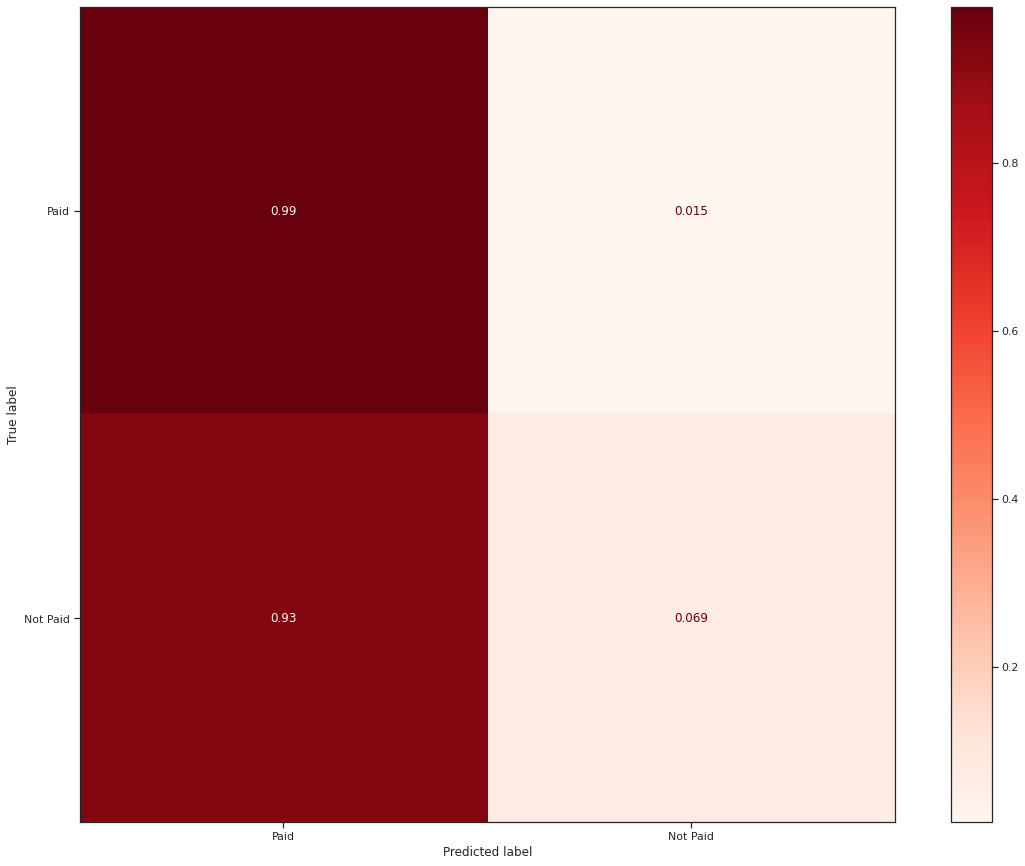

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, l1_pred, display_labels = 
                                        labels, cmap='Reds', normalize='true');

In [ ]:
print('Classification Report for Training Set')
logreg_l1_report = classification_report(y_test, l1_pred)
print(logreg_l1_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3998
           1       0.54      0.07      0.12      1002

    accuracy                           0.80      5000
   macro avg       0.67      0.53      0.51      5000
weighted avg       0.75      0.80      0.73      5000



Logistic Regression Model (L2 Tuning)

The model determines the highest value would be when c = 0.1.

{1e-05: 0.8008,
 0.0001: 0.8012,
 0.001: 0.803,
 0.01: 0.8004,
 0.1: 0.8016,
 1: 0.8012,
 10: 0.8012,
 100: 0.8012,
 1000: 0.8012,
 10000: 0.8012}

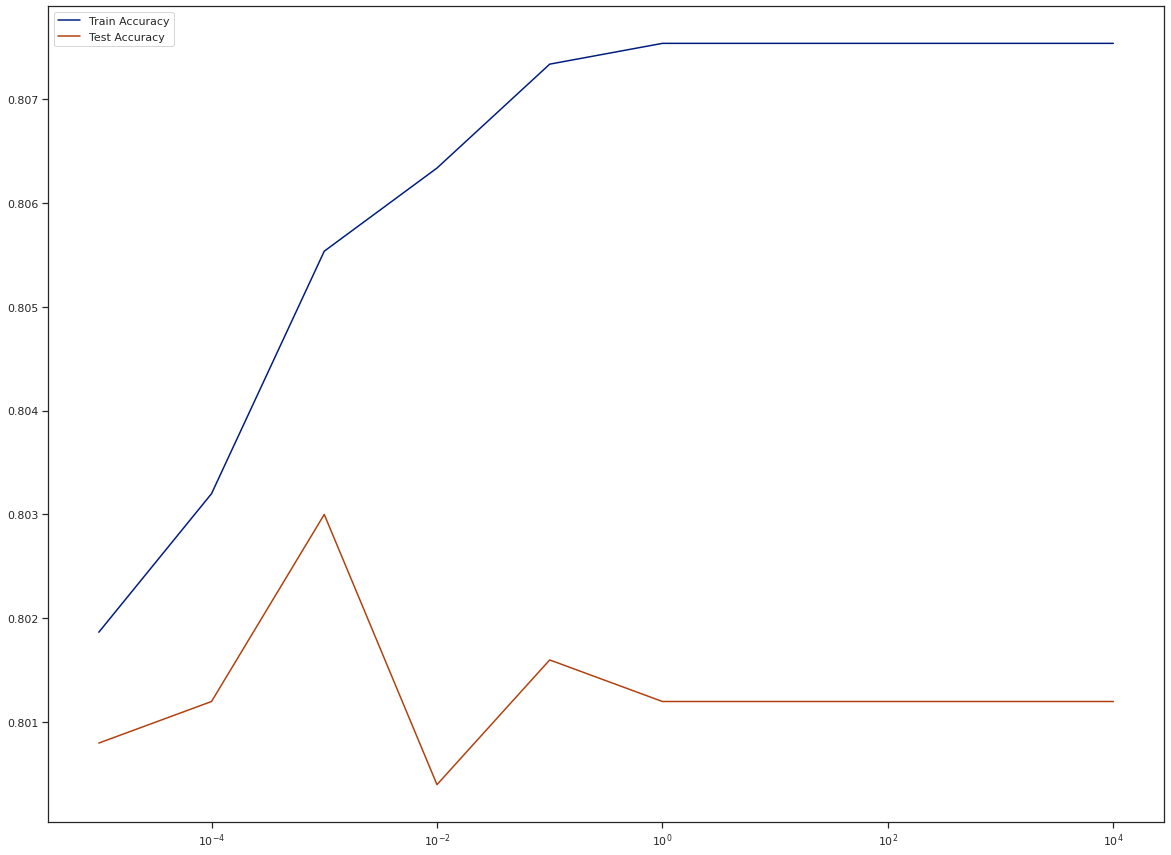

In [ ]:
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train_score = []
test_score = []

for c in c_values:
  logreg_l2 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  logreg_l2_pipe = make_pipeline(preprocessor, logreg_l2)
  logreg_l2_pipe.fit(X_train, y_train)

  train_score.append(logreg_l2_pipe.score(X_train, y_train))
  test_score.append(logreg_l2_pipe.score(X_test, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_score, label='Train Accuracy')
ax.plot(c_values, test_score, label='Test Accuracy')
ax.set_xticks(c_values)
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_score)}

In [ ]:
l2_01 = LogisticRegression(C=0.1, max_iter=1000, solver='liblinear', penalty='l2')
l2_01_pipe = make_pipeline(preprocessor, l2_01)
l2_01_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000, solver='liblinear'))])

In [ ]:
l2_pred = l2_01_pipe.predict(X_test)
l2_pred

array([0, 0, 0, ..., 0, 0, 0])

From the Confusion Matrix below, we can see our true positives equate to 98% but our true negatives were 7%. The model predicted 93% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. When comparing the two tuned models, this model would be the better choice.

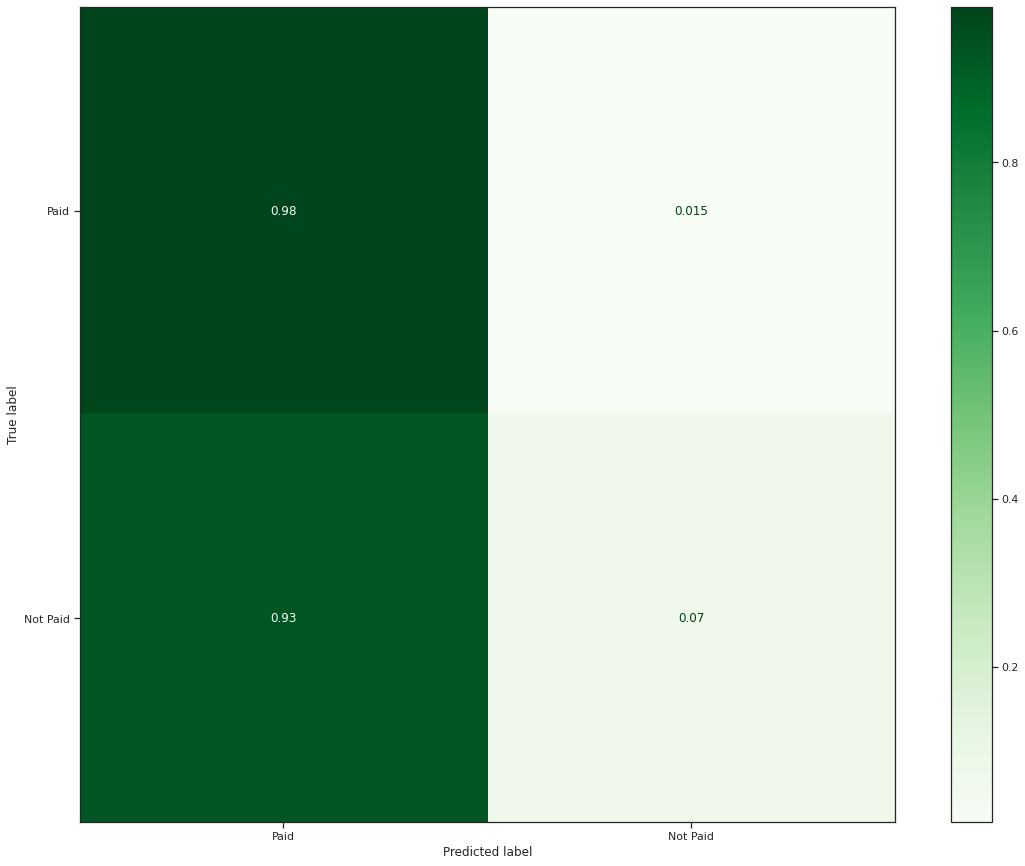

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, l2_pred, display_labels = 
                                        labels, cmap='Greens', normalize='true');

In [ ]:
print('Classification Report for Training Set')
logreg_l2_report = classification_report(y_test, l2_pred)
print(logreg_l2_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3998
           1       0.54      0.07      0.12      1002

    accuracy                           0.80      5000
   macro avg       0.67      0.53      0.51      5000
weighted avg       0.75      0.80      0.73      5000



Logistic Regression L1 Tuning with PCA

In [ ]:
pca = PCA(n_components=.95)
log_pca_pipe = make_pipeline(preprocessor, pca, logreg)
log_pca_pipe.fit(X_train, y_train)
print(log_pca_pipe.score(X_train, y_train))
print(log_pca_pipe.score(X_test, y_test))

0.8074
0.801


The model determines the highest value would be when c = 1.

{1e-05: 0.7996,
 0.0001: 0.7996,
 0.001: 0.7996,
 0.01: 0.802,
 0.1: 0.8008,
 1: 0.801,
 10: 0.8008,
 100: 0.8008,
 1000: 0.8008,
 10000: 0.8008}

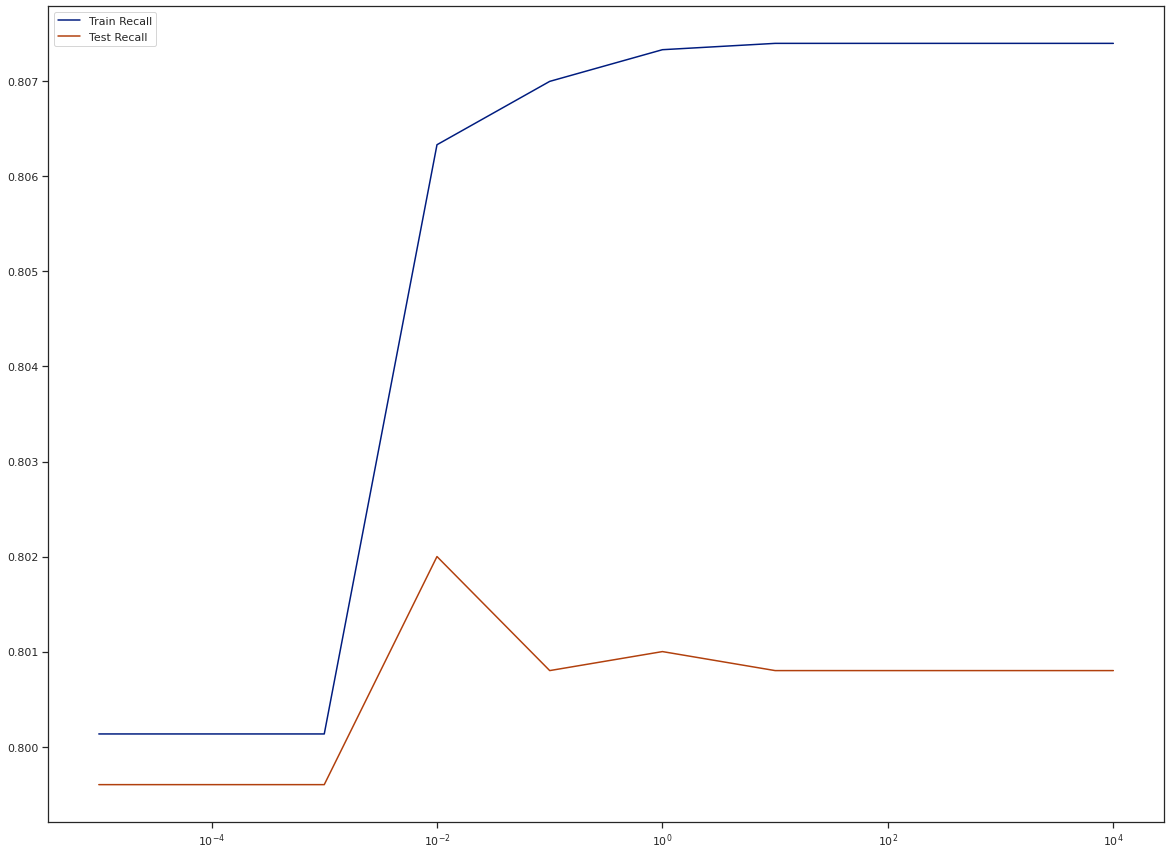

In [ ]:
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train_score = []
test_score = []

for c in c_values:
  log_pca_l1 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_pca_l1_pipe = make_pipeline(preprocessor, pca, log_pca_l1)
  log_pca_l1_pipe.fit(X_train, y_train)

  train_score.append(log_pca_l1_pipe.score(X_train, y_train))
  test_score.append(log_pca_l1_pipe.score(X_test, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_score, label='Train Recall')
ax.plot(c_values, test_score, label='Test Recall')
ax.set_xticks(c_values)
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_score)}

In [ ]:
l1_pca_01 = LogisticRegression(C=1, max_iter=1000, solver='liblinear', penalty='l1')
l1_pca_01_pipe = make_pipeline(preprocessor, scaler, pca, l1_01)
l1_pca_01_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
l1_pca_pred = l1_pca_01_pipe.predict(X_test)
l1_pca_pred

array([0, 0, 0, ..., 0, 0, 0])

From the Confusion Matrix below, we can see our true positives equate to 98% but our true negatives were 6.8%. The model predicted 93% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. When comparing the models, Logistic Regression Model L2 Tuning would be the better choice.

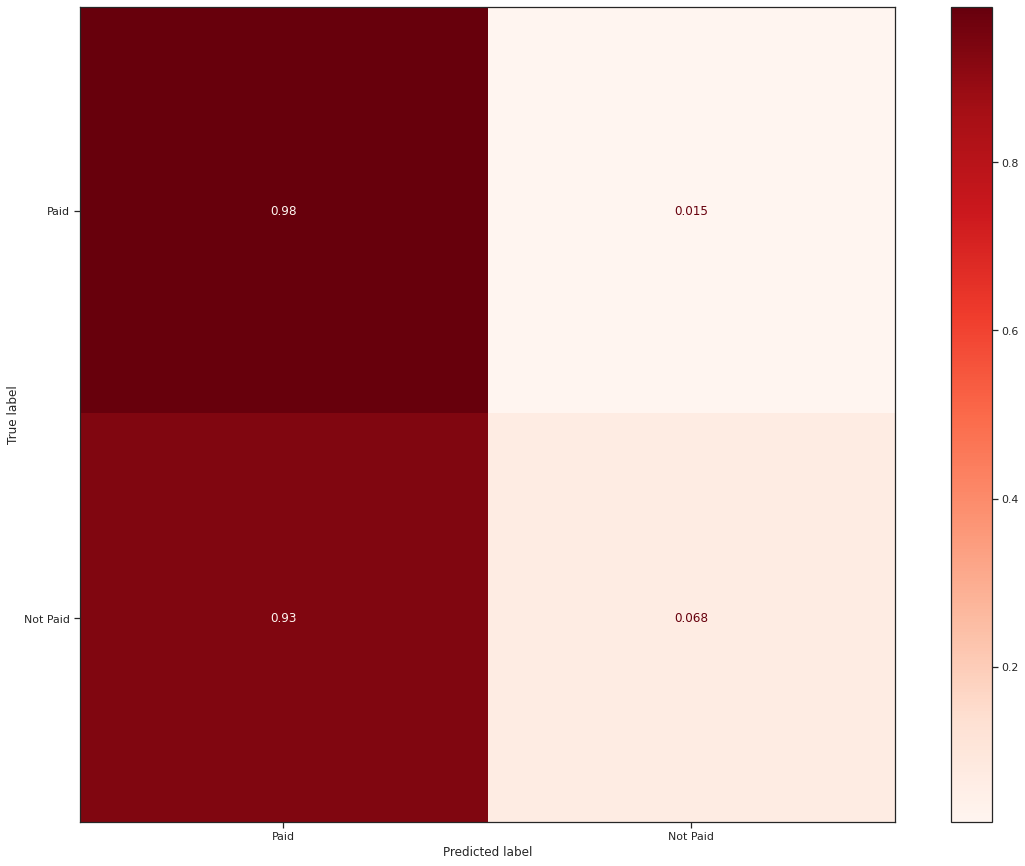

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, l1_pca_pred, display_labels = 
                                        labels, cmap='Reds', normalize='true');

K-Nearest Neighbors Model

In [ ]:
knn_tune = np.zeros(25)
for i in range(1,21):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn_pipe = make_pipeline(preprocessor, knn)
  knn_pipe.fit(X_train, y_train)
  tune_pred = knn_pipe.predict(X_test)
  knn_tune[i-1] = metrics.accuracy_score(y_test, tune_pred)

best_n = np.argmax(knn_tune) + 1
best_n

19

From the algorithm above, we have found the best prediction for accuracy will have a n_neighbors of 19.

In [ ]:
knn_19 = KNeighborsClassifier(n_neighbors=19)
knn_19_pipe = make_pipeline(preprocessor, knn_19)
knn_19_pipe.fit(X_train, y_train)
print(knn_19_pipe.score(X_train, y_train))
print(knn_19_pipe.score(X_test, y_test))

0.8106
0.8042


In [ ]:
knn_19_pred = knn_19_pipe.predict(X_test)
knn_19_pred

array([0, 0, 0, ..., 0, 0, 0])

From the Confusion Matrix below, we can see our true positives equate to 98% but our true negatives were 9%. The model predicted 91% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. When comparing the models, this model would be the better choice.

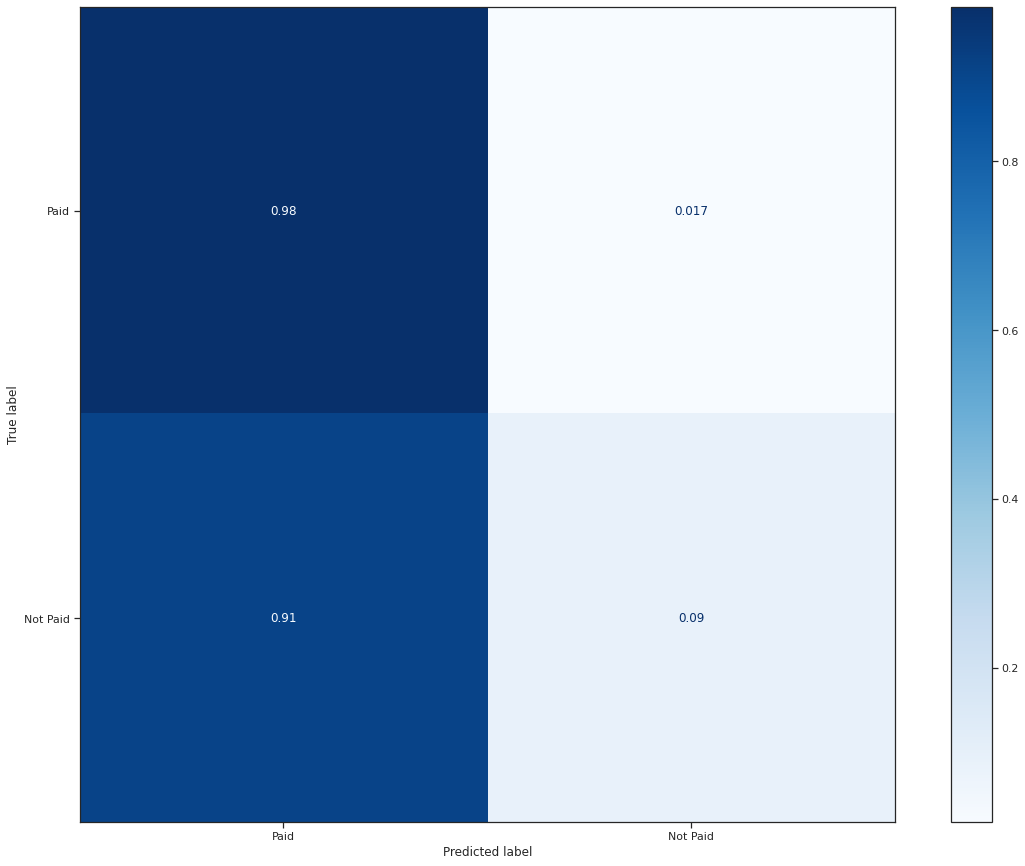

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, knn_19_pred, display_labels = 
                                        labels, cmap='Blues', normalize='true');

In [ ]:
print('Classification Report for Training Set')
knn_report = classification_report(y_test, knn_19_pred)
print(knn_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3998
           1       0.57      0.09      0.16      1002

    accuracy                           0.80      5000
   macro avg       0.69      0.54      0.52      5000
weighted avg       0.76      0.80      0.74      5000



KNN with PCA

In [ ]:
knn_pca_tune = np.zeros(25)
for i in range(1,21):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn_pca_pipe = make_pipeline(preprocessor, pca, knn)
  knn_pca_pipe.fit(X_train, y_train)
  tune_pca_pred = knn_pca_pipe.predict(X_test)
  knn_pca_tune[i-1] = metrics.accuracy_score(y_test, tune_pca_pred)

best_n = np.argmax(knn_pca_tune) + 1
best_n

19

From the algorithm above, we have found the best prediction for accuracy will have a n_neighbors of 19 when applying PCA to the KNN model.

In [ ]:
knn_pca_19 = KNeighborsClassifier(n_neighbors=19)
knn_pca_19_pipe = make_pipeline(preprocessor, scaler, pca, knn_19)
knn_pca_19_pipe.fit(X_train, y_train)
print(knn_pca_19_pipe.score(X_train, y_train))
print(knn_pca_19_pipe.score(X_test, y_test))

0.8094
0.8032


In [ ]:
knn_pca_19_pred = knn_pca_19_pipe.predict(X_test)
knn_pca_19_pred

array([0, 0, 0, ..., 0, 0, 0])

Similar to the KNN model without PCA, we can see our true positives equate to 98% but our true negatives were 9%. The model predicted 91% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. When comparing the models, this model would be the better choice.

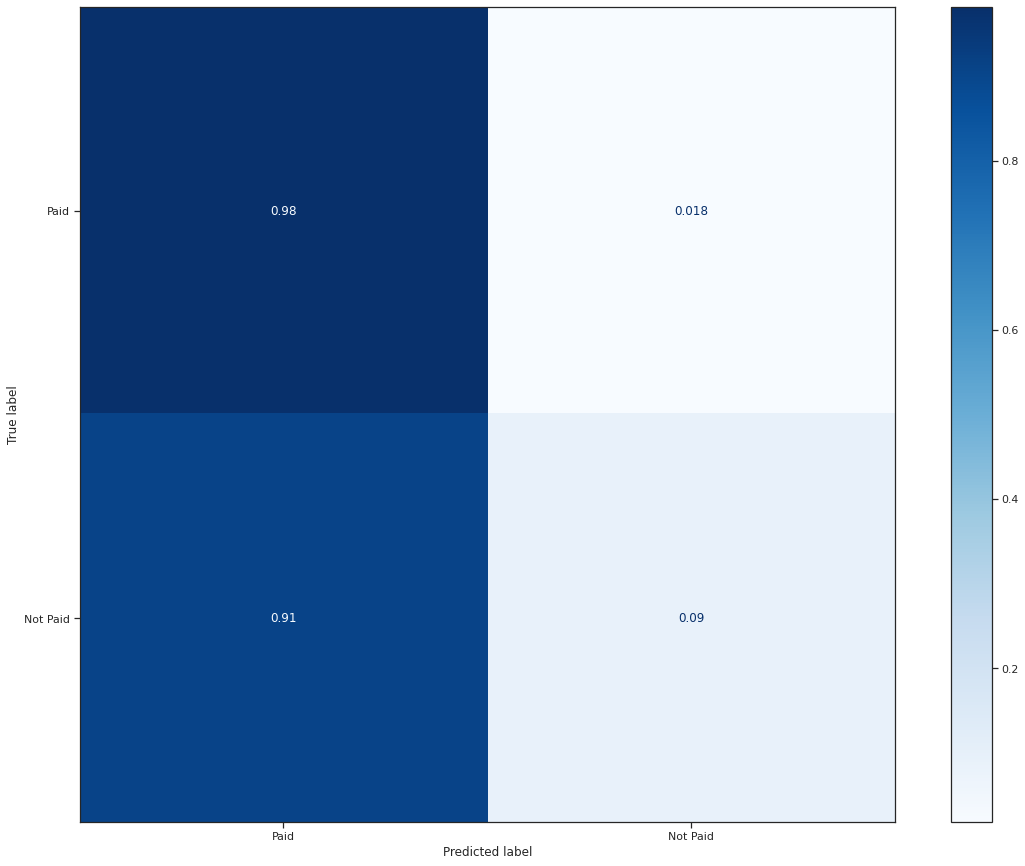

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, knn_pca_19_pred, display_labels = 
                                        labels, cmap='Blues', normalize='true');

Random Forest Model

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
rf_pipe.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
rf_train_score = rf_pipe.score(X_train, y_train)
rf_test_score = rf_pipe.score(X_test, y_test)
print(rf_train_score)
print(rf_test_score)

1.0
0.799


In [ ]:
est_depth = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depth)

49

From the algorithm below, we have determined with a random forest model of 49 depth, the most accurate depth would be when max depth is equal to 7.

In [ ]:
depths = range(1, max(est_depth))
score = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   rf = RandomForestClassifier(max_depth=depth)
   rf_pipe = make_pipeline(preprocessor, rf)
   rf_pipe.fit(X_train, y_train)
   score.loc[depth, 'Train Score'] = rf_pipe.score(X_train, y_train)
   score.loc[depth, 'Test Score'] = rf_pipe.score(X_test, y_test)
   score.head()

sorted_score = score.sort_values(by='Test Score', ascending=False)
sorted_score.head()

,Test Score,Train Score
7,0.8036,0.810667
8,0.8028,0.812400
9,0.8024,0.816133
10,0.8024,0.822600
30,0.8022,0.999867


In [ ]:
rf_7 = RandomForestClassifier(max_depth=7, random_state=42)
rf_7_pipe = make_pipeline(preprocessor, rf)
rf_7_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=48))])

In [ ]:
rf_7_pred = rf_7_pipe.predict(X_test)
rf_7_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
rf_7_train_score = rf_7_pipe.score(X_train, y_train)
rf_7_test_score = rf_7_pipe.score(X_test, y_test)
print(rf_7_train_score)
print(rf_7_test_score)

1.0
0.8022


From the Confusion Matrix below, we can see our true positives equate to 98% but our true negatives were 10%. The model predicted 90% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. When comparing the models, this model would be the better choice.

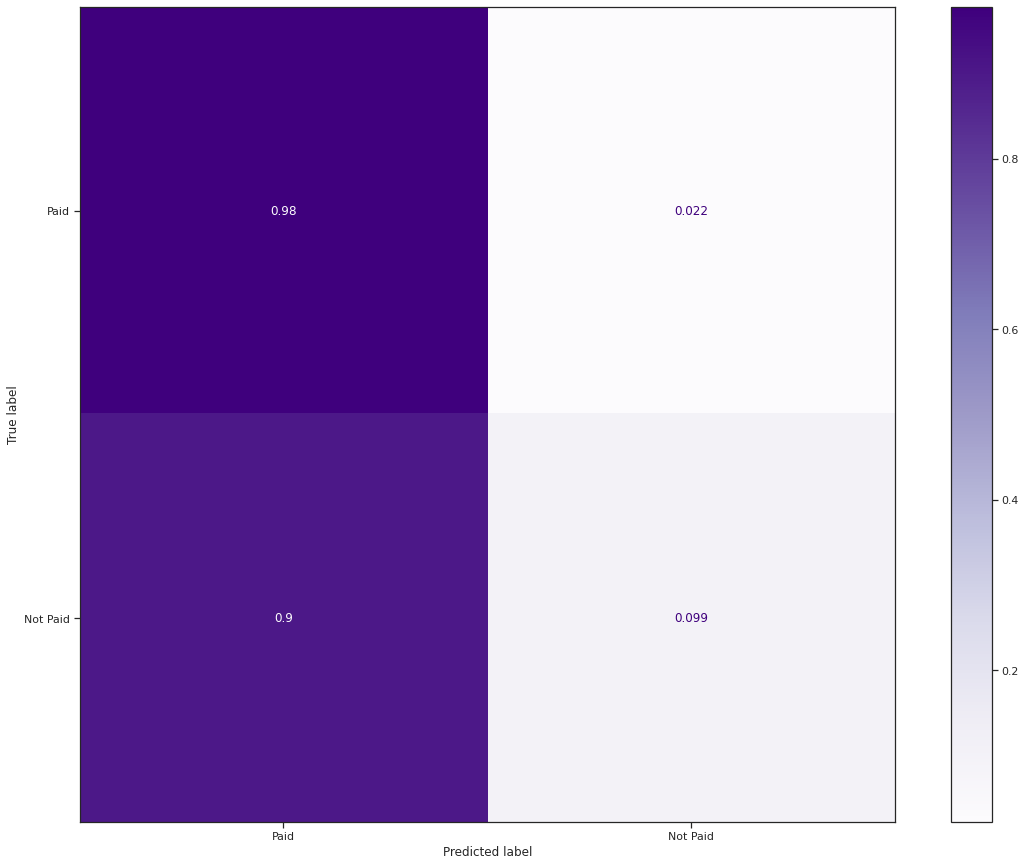

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, rf_7_pred, 
                                        display_labels = labels, 
                                        cmap='Purples', normalize='true');

In [ ]:
print('Classification Report for Training Set')
rf_report = classification_report(y_test, rf_7_pred)
print(rf_report)

Classification Report for Training Set
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3998
           1       0.54      0.10      0.17      1002

    accuracy                           0.80      5000
   macro avg       0.67      0.54      0.53      5000
weighted avg       0.76      0.80      0.74      5000



Random Forest Classification with PCA

In [ ]:
rf_pca_pipe = make_pipeline(preprocessor, scaler, pca, rf)
rf_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=48))])

In [ ]:
rf_pca_pipe.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
rf_pca_train_score = rf_pca_pipe.score(X_train, y_train)
rf_pca_test_score = rf_pca_pipe.score(X_test, y_test)
print(rf_pca_train_score)
print(rf_pca_test_score)

0.9999333333333333
0.7988


In [ ]:
est_depth = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depth)

48

From the algorithm below, we have determined with a PCA random forest model of 48 depth, the most accurate depth would be when max depth is equal to 29.

In [ ]:
depths = range(1, max(est_depth))
score = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   rf = RandomForestClassifier(max_depth=depth)
   rf_pipe = make_pipeline(preprocessor, pca, rf)
   rf_pca_pipe.fit(X_train, y_train)
   score.loc[depth, 'Train Score'] = rf_pca_pipe.score(X_train, y_train)
   score.loc[depth, 'Test Score'] = rf_pca_pipe.score(X_test, y_test)
   score.head()

sorted_score = score.sort_values(by='Test Score', ascending=False)
sorted_score.head()

,Test Score,Train Score
29,0.801,1.000000
16,0.801,1.000000
12,0.801,1.000000
22,0.8002,0.999933
1,0.7998,1.000000


In [ ]:
rf_29 = RandomForestClassifier(max_depth=29, random_state=42)
rf_pca_29_pipe = make_pipeline(preprocessor, scaler, pca, rf)
rf_pca_29_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab5212d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8ab521ed0>)])),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=47))])

In [ ]:
rf_pca_29_pred = rf_pca_29_pipe.predict(X_test)
rf_pca_29_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
rf_pca_29_train_score = rf_pca_29_pipe.score(X_train, y_train)
rf_pca_29_test_score = rf_pca_29_pipe.score(X_test, y_test)
print(rf_pca_29_train_score)
print(rf_pca_29_test_score)

1.0
0.7988


From the Confusion Matrix below, we can see our true positives equate to 97% but our true negatives were 12%. The model predicted 88% of the data to have their loans paid when the loan was not paid. This can create an issue if the model were produced because Lending Tree does not want to report their borrowers have paid off their loan when they haven't. When comparing the models, this model would be the better choice.

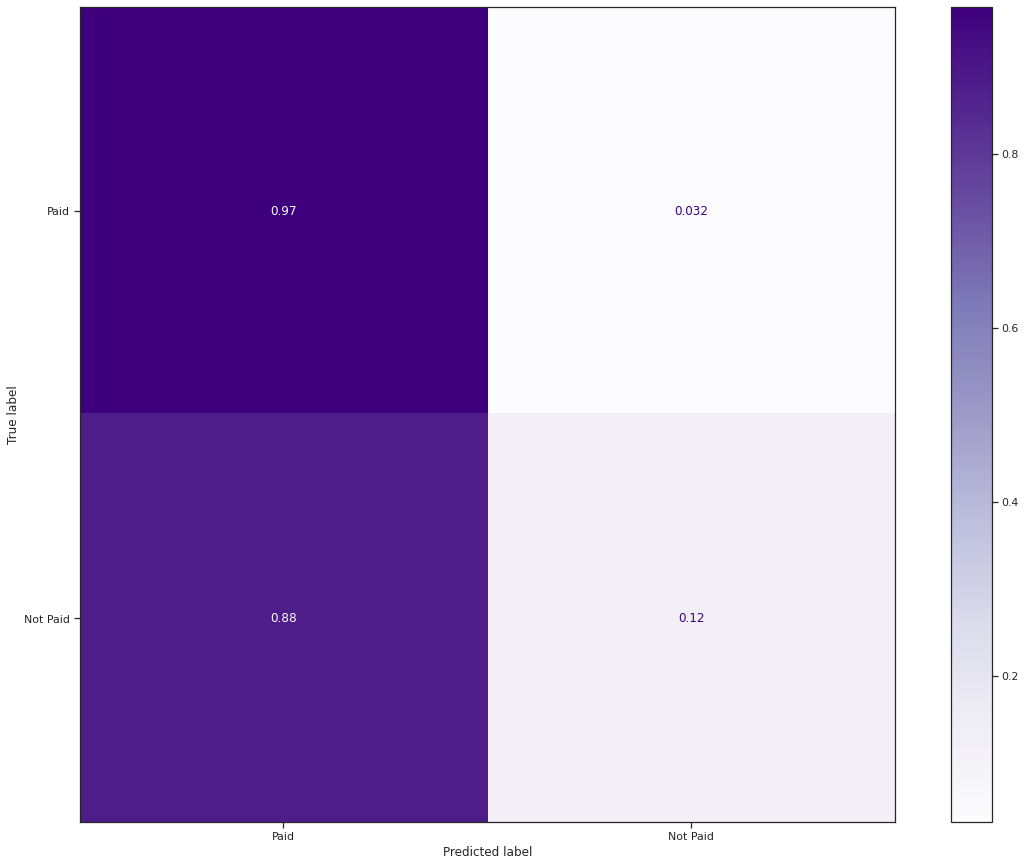

In [ ]:
labels=['Paid', 'Not Paid']
ConfusionMatrixDisplay.from_predictions(y_test, rf_pca_29_pred, 
                                        display_labels = labels, 
                                        cmap='Purples', normalize='true');

From the Logistic Regression, KNN, and Random Forest models, the best machine learning model would be the Random Forest model with PCA because it maximized the predictive capability of the risk of future loan defaults. Though the false positives were high, the Random Forest model provided the highest number of true negatives, which minimizes false reports for Lending Tree. This way, Lending Tree can have a better probability to predict if borrowers will not pay and prevent the risk as much as possible.